In [2]:
import numpy as np
import scipy.integrate as integrate
import scipy.optimize as optimize
import matplotlib.pyplot as plt
import emcee
import corner

%matplotlib inline

## Part (a) &mdash; Generate samples from power-law IMF

In [3]:
# def power_law_samples(N, M_min, M_max, alpha):
#     """Function that generates samples from a power law distribution.
#     Parameters:
#     N: number of samples to be generated
#     M_min: lower bound
#     M_max: upper bound
#     alpha: power law index"""
    
#     # list to store our samples
#     Ms = []
#     # Internet says it's computationally more efficient to sample in log space
#     logMmin = np.log10(M_min)
#     logMmax = np.log10(M_max)
#     # generate the samples
#     while len(Ms) < N:
#         logM = np.random.uniform(logMmin, logMmax)
#         M = 10**logM
#         likelihood = M ** (-alpha)
#         # use rejection method
#         r = np.random.uniform(M_max**(-alpha), M_min**(-alpha))
#         if r < likelihood:
#             Ms.append(M)
            
#     return Ms

def power_law_samples(N, M_min, M_max, alpha):
    """Function that generates samples from a power law distribution.
    Parameters:
    N: number of samples to be generated
    M_min: lower bound
    M_max: upper bound
    alpha: power law index"""
    
    #u = np.random.uniform(0.0,1.0,size=N)
#     c = (float(M_max)/M_min)**(-alpha+1) - 1
#     Ms = M_min * (1 + c * u)**(1./(-alpha+1))
#     c = M_max**(1-alpha) - M_min**(1-alpha)
#     Ms = (M_max**(1-alpha) - c*u )**(1./(1-alpha))
    # 3rd try is the charm!
    num_samples = 0
    Ms = np.array([])
    while num_samples < N:
        r = np.random.uniform(0.0,1.0)
        M = M_min * (1-r)**(-1/(alpha-1))
        if M > M_max:
            continue
        else:
            Ms = np.append(Ms, M)
            num_samples += 1
            
    return Ms

$C = \frac{1}{\int M^{-\alpha} dM}$

$ C = \frac{1-\alpha}{M^{1-\alpha} - m^{1-\alpha}}$

$p = \frac{1-\alpha}{M^{1-\alpha} - m^{1-\alpha}} M^{-\alpha}$

$ P = \frac{1-\alpha}{M_{max}^{1-\alpha} - M_{min}^{1-\alpha}} \frac{M^{1-\alpha} - M_{min}^{1-\alpha}}{1-\alpha} = u$

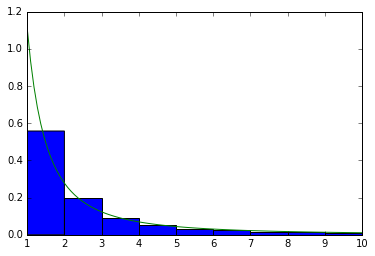

In [110]:
### let's generate some data
np.random.seed(11)
fake_sample_1 = power_law_samples(1000, 3, 15, 1.35)
bins = [1,2,3,4,5,6,7,8,9,10]
plt.hist(fake_sample_1, bins=bins, normed=True)
plt.plot(np.linspace(1,10,100),np.linspace(1,10,100)**(-2.)/0.9) # <- 0.9 is normalization spit out by Mathematica
plt.show()

## Part (b) &mdash; Parameter estimation on fake data from Part (a)

In [111]:
### probabilites here
def lnlike(alpha, M_min, M_max, M):
    norm = integrate.quad(lambda x: x**(-alpha), M_min, M_max) # as defined in pset, c = 1/norm[0]
    return np.sum(- np.log(norm[0]) - alpha * np.log(M))

def lnprior(alpha):
    # let's assume flat priors
    if 1.0 < alpha < 5.0:
        return 0.0
    return -np.inf

def lnprob(alpha, M_min, M_max, M):
    lp = lnprior(alpha)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(alpha, M_min, M_max, M)

In [120]:
### now let's set up emcee
fake_sample_1 = np.asarray(fake_sample_1)
ndim, nwalkers = 1, 100
pos = [np.array([np.random.uniform(1.,3.)]) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[1, 10, fake_sample_1])
sampler.run_mcmc(pos, 1000);

In [121]:
np.mean(sampler.acceptance_fraction)

0.80152000000000001

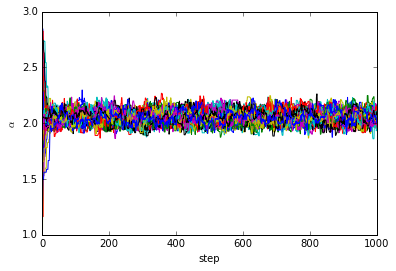

In [122]:
[plt.plot(sampler.chain[i,:,0]) for i in range(50)]
#[plt.plot(sampler.chain[i,:,0]) for i in range(sampler.chain.shape[0])]
plt.xlabel('step')
plt.ylabel(r'$\alpha$')
plt.show()

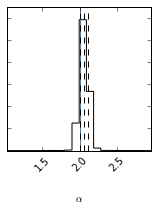

In [123]:
### corner plot
samples = sampler.chain[:,:, :].reshape((-1, ndim))
fig2 = corner.corner(samples, labels=[r"$\alpha$"], quantiles=[0.16, 0.5, 0.84], truths=[2.])
plt.show(fig2)

## Part (c) &mdash; Generate a new fake data set and do parameter estimation

In [11]:
### new fake data set
N = 1000
M_min = 3
M_max = 15
alpha = 2.35
fake_sample_2 = power_law_samples(N, M_min, M_max, alpha)

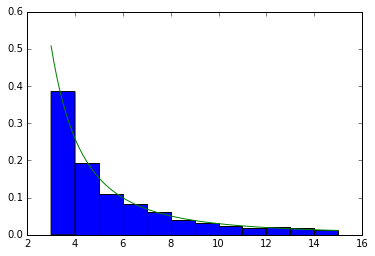

In [12]:
bins = [3,4,5,6,7,8,9,10,11,12,13,14,15]
plt.hist(fake_sample_2, bins=bins, normed=True)
plt.plot(np.linspace(3,15,100),np.linspace(3,15,100)**(-2.35)/0.148954)
plt.show()

In [13]:
print max(fake_sample_2)

14.9524834838


In [4]:
### probabilites here
def lnlike(theta, M_min, M):
    M_max, alpha = theta[0], theta[1]
    #norm = integrate.quad(lambda x: x**(-alpha), M_min, M_max) # as defined in pset, c = 1/norm[0]
    norm = (1.-alpha)/(M_max**(1.-alpha) - M_min**(1.-alpha))
    return np.sum(np.log(norm) - alpha * np.log(M))

def lnprior(theta, M):
    M_max, alpha = theta[0], theta[1]
    # let's assume flat priors
    if 14. < M_max < 20. and 1.0 < alpha < 6.0:
        return 0.0
    return -np.inf

def lnprob(theta, M_min, M):
    lp = lnprior(theta, M)
    ll = lnlike(theta, M_min, M)
    if not np.isfinite(lp):
        return -np.inf
    return lp + ll

In [8]:
### MLE because I don't understand why emcee refuses to work
nll = lambda *args: -lnlike(*args)
result = optimize.minimize(nll, [15., 2.35], args=(3., fake_sample_2), bounds=((0.0, None),(1.0, None)))
M_max_ml, alpha_ml = result["x"]
print M_max_ml, alpha_ml

15.0 2.35


/Users/iene/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in double_scalars


In [16]:
### now let's set up emcee
fake_sample_2 = np.sort(fake_sample_2)
fake_sample_2 = fake_sample_2[fake_sample_2<10]
ndim, nwalkers = 2, 200
pos = [np.array([np.random.uniform(14.8,15.2), np.random.uniform(2,3)]) for i in range(nwalkers)]
#pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[3., fake_sample_2])
pos1, prob, state = sampler.run_mcmc(pos, 3000)
#sampler.reset()
#sampler.run_mcmc(pos1, 2000, rstate0=state);

In [10]:
np.mean(sampler.acceptance_fraction)

0.66180666666666665

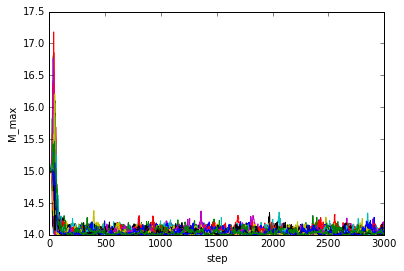

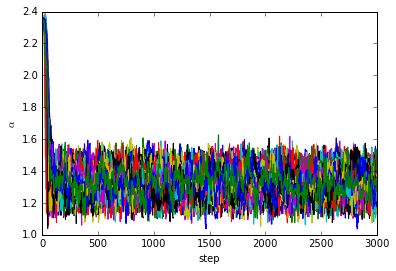

In [11]:
[plt.plot(sampler.chain[i,:,0]) for i in range(100)]
#[plt.plot(sampler.chain[i,:,0]) for i in range(sampler.chain.shape[0])]
plt.xlabel('step')
plt.ylabel(r'M_max')
plt.show()

[plt.plot(sampler.chain[i,:,1]) for i in range(100)]
#[plt.plot(sampler.chain[i,:,0]) for i in range(sampler.chain.shape[0])]
plt.xlabel('step')
plt.ylabel(r'$\alpha$')
plt.show()

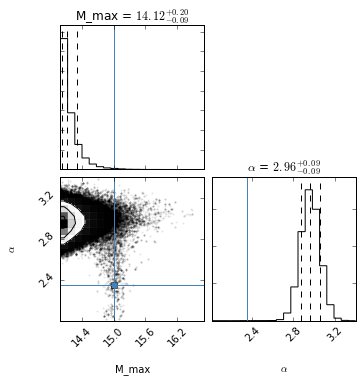

In [17]:
### corner plot
samples = sampler.chain[:,:, :].reshape((-1, ndim))
fig3 = corner.corner(samples, labels=["M_max", r"$\alpha$"], quantiles=[0.16, 0.5, 0.84], truths=[15, 2.35], \
                    show_titles=True)
plt.show(fig3)

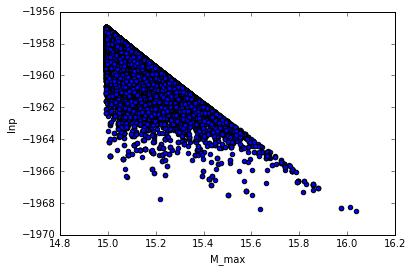

In [200]:
[plt.scatter(sampler.chain[i,:,0], sampler.lnprobability[i,:]) for i in range(50)]
plt.xlabel('M_max')
plt.ylabel('lnp');

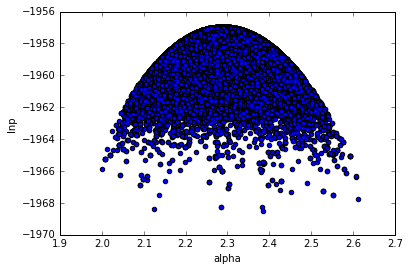

In [201]:
[plt.scatter(sampler.chain[i,:,1], sampler.lnprobability[i,:]) for i in range(50)]
plt.xlabel('alpha')
plt.ylabel('lnp');

## Part (d)

We want to show how the precision to which we can recover $\alpha$ and $M_\text{max}$ depends on the number of sample points. To this end, we will generate a bunch of samples and use our inference code to see what results we get.

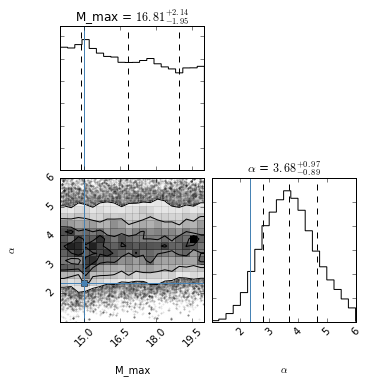

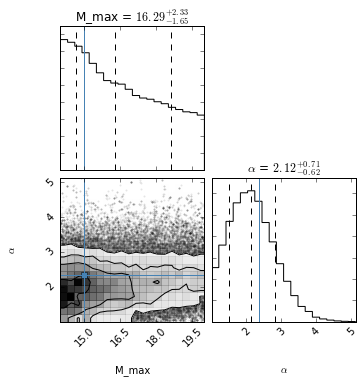

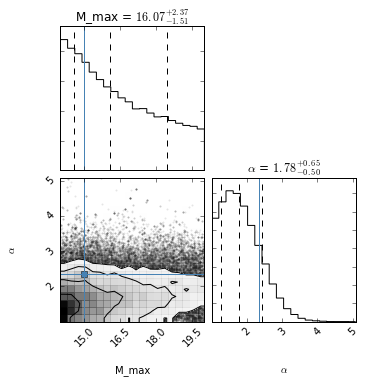

In [7]:
### try this a bunch of times for N=10
for i in range(3):
    N = 10
    M_min = 3
    M_max = 15
    alpha = 2.35
    sample = power_law_samples(N, M_min, M_max, alpha)
    
    ### now let's set up emcee
    ndim, nwalkers = 2, 100
    pos = [np.array([np.random.uniform(14.8,15.2), np.random.uniform(2,3)]) for i in range(nwalkers)]
    #pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[3., sample])
    pos1, prob, state = sampler.run_mcmc(pos, 1000)
    #sampler.reset()
    #sampler.run_mcmc(pos1, 2000, rstate0=state);
    
    samples = sampler.chain[:,:, :].reshape((-1, ndim))
    fig4 = corner.corner(samples, labels=["M_max", r"$\alpha$"], quantiles=[0.16, 0.5, 0.84], truths=[15, 2.35],\
                        show_titles=True)
    plt.show(fig4)

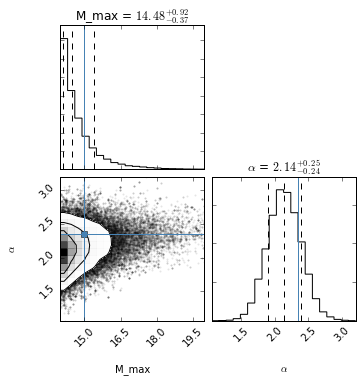

In [8]:
### now for N=100
N = 100
M_min = 3
M_max = 15
alpha = 2.35
sample = power_law_samples(N, M_min, M_max, alpha)

### now let's set up emcee
ndim, nwalkers = 2, 100
pos = [np.array([np.random.uniform(14.8,15.2), np.random.uniform(2,3)]) for i in range(nwalkers)]
#pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[3., sample])
pos1, prob, state = sampler.run_mcmc(pos, 1000)
#sampler.reset()
#sampler.run_mcmc(pos1, 2000, rstate0=state);

samples = sampler.chain[:,:, :].reshape((-1, ndim))
fig4 = corner.corner(samples, labels=["M_max", r"$\alpha$"], quantiles=[0.16, 0.5, 0.84], truths=[15, 2.35],\
                    show_titles=True)
plt.show(fig4)

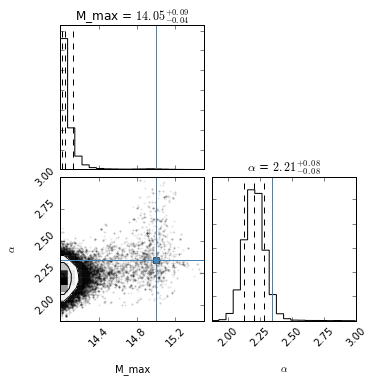

In [9]:
### N=1000
N = 1000
M_min = 3
M_max = 15
alpha = 2.35
sample = power_law_samples(N, M_min, M_max, alpha)

### now let's set up emcee
ndim, nwalkers = 2, 100
pos = [np.array([np.random.uniform(14.8,15.2), np.random.uniform(2,3)]) for i in range(nwalkers)]
#pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[3., sample])
pos1, prob, state = sampler.run_mcmc(pos, 1000)
#sampler.reset()
#sampler.run_mcmc(pos1, 2000, rstate0=state);

samples = sampler.chain[:,:, :].reshape((-1, ndim))
fig4 = corner.corner(samples, labels=["M_max", r"$\alpha$"], quantiles=[0.16, 0.5, 0.84], truths=[15, 2.35],\
                    show_titles=True)
plt.show(fig4)

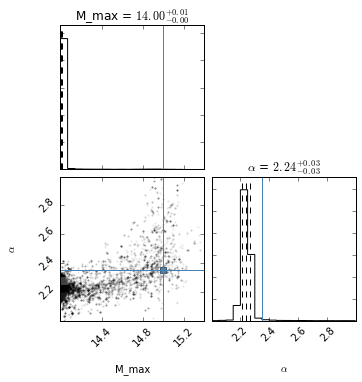

In [10]:
### N=10000
N = 10000
M_min = 3
M_max = 15
alpha = 2.35
sample = power_law_samples(N, M_min, M_max, alpha)

### now let's set up emcee
ndim, nwalkers = 2, 100
pos = [np.array([np.random.uniform(14.8,15.2), np.random.uniform(2,3)]) for i in range(nwalkers)]
#pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[3., sample])
pos1, prob, state = sampler.run_mcmc(pos, 1000)
#sampler.reset()
#sampler.run_mcmc(pos1, 2000, rstate0=state);

samples = sampler.chain[:,:, :].reshape((-1, ndim))
fig4 = corner.corner(samples, labels=["M_max", r"$\alpha$"], quantiles=[0.16, 0.5, 0.84], truths=[15, 2.35],\
                    show_titles=True)
plt.show(fig4)